In [165]:
#ALL IMPORTS
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import *
import keras


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix


from tensorflow.keras import datasets, layers, models,callbacks
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

import skimage

In [174]:
!jt -r

Reset css and font defaults in:
C:\Users\hp\.jupyter\custom &
C:\Users\hp\AppData\Roaming\jupyter\nbextensions


In [166]:
#LOADING IMAGES FROM DATASET
import cv2
import os

def load_images_from_folder(folder):
    images = []
    names=[]
    for filename in os.listdir(folder):
        if len(names)>=100: #for balanced data
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            if folder=='D:/SEM 3/PROJECT/grey/signal' :
                names.append(0)
            else: names.append(1)
    return images, names

signal, s_names = load_images_from_folder('D:/SEM 3/PROJECT/grey/signal')
bg, bg_names = load_images_from_folder('D:/SEM 3/PROJECT/grey/background')


In [168]:
#NUMBER OF SAMPLES IN THE DATASET
print("Number of Signal events in dataset:", len(signal))
print("Number of Background events dataset:", len(bg))

Number of Signal events in dataset: 100
Number of Background events dataset: 100


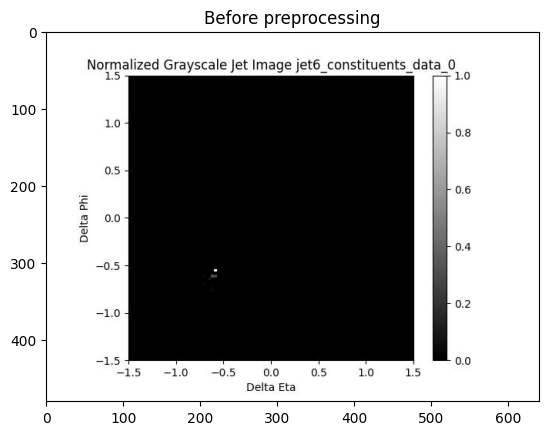

In [150]:
#EXAMPLE SIGNAL IMAGE BEFORE CROPPING AND PREPROCESSING
plt.imshow(signal[0],cmap='grey')
plt.title("Before preprocessing")
plt.savefig('Before preprocessing.png')
plt.show()

In [151]:
#PREPRCOESSING: RESIZING AND CROPPING IMAGES
for i in range(len(signal)):
    signal[i] = signal[i][260:380,150:300]
    signal[i]=skimage.transform.resize(signal[i],(64,64,1),mode='constant',preserve_range=True)
    bg[i]= bg[i][260:380,150:300]
    bg[i]=skimage.transform.resize(bg[i],(64,64,1),mode='constant',preserve_range=True)


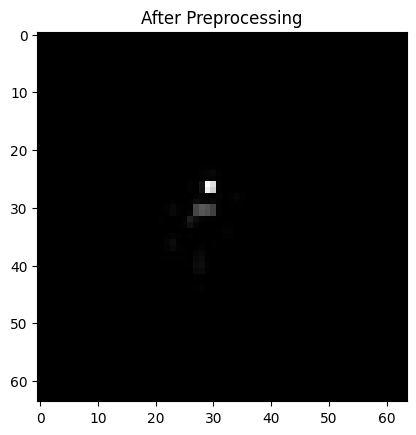

In [152]:
#EXAMPLE IMAGE AFTER PREPROCESSING
plt.imshow(signal[0], cmap='grey')
plt.title("After Preprocessing")
plt.savefig('After preprocessing.png')
plt.show()

In [153]:
#CREATING TRAINING TESTING AND VALIDATION DATASETS

x=np.array(signal+bg) #numpy array of images
y=np.array(s_names+bg_names) #numpy array of class labels

#split all signal images into 20% test 80% train ==> 0.2 TEST
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#split 80% train into 25% (0.8*0.25) validation and 75% (0.8*0.75) train ==> 0.6 TRAIN 0.2 VALIDATION
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)


In [129]:
#CREATING THE CNN MODEL
model = Sequential()

# Add the first Convolutional layer with L2 regularization
model.add(Conv2D(32, (11, 11), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(64, 64, 1)))

# Add the first MaxPooling layer
model.add(MaxPooling2D(2, 2))

# Add the second layer: Dropout
model.add(Dropout(0.2))

# Add the second Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the second MaxPooling layer
model.add(MaxPooling2D(3, 3))

model.add(Dropout(0.2))
# Add the third Convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Add the third MaxPooling layer
model.add(MaxPooling2D(3, 3))

# Add Local Response Normalization
model.add(Lambda(tf.nn.lrn))

# Flatten the output before the Fully Connected layer
model.add(Flatten())

# Add a Dropout layer before the first Fully Connected layer
model.add(Dropout(0.2))

# Add the Fully Connected layer with 64 units
model.add(Dense(64, activation='relu'))

# Add a Dropout layer before the output layer
model.add(Dropout(0.1))

# Add the output layer with a Sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 54, 54, 32)        3904      
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 27, 27, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_67 (Dropout)        (None, 27, 27, 32)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_68 (Dropout)        (None, 8, 8, 32)        

In [130]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1.e-3),
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')]
)

In [131]:
#FITTING THE MODEL
history= model.fit(x_train, y_train, epochs=40,shuffle=False,batch_size=30, validation_data=(x_val, y_val),verbose=2)

Epoch 1/40
4/4 - 3s - loss: 1.3843 - accuracy: 0.4917 - auc_18: 0.4646 - val_loss: 1.3335 - val_accuracy: 0.5750 - val_auc_18: 0.3568 - 3s/epoch - 627ms/step
Epoch 2/40
4/4 - 0s - loss: 1.3296 - accuracy: 0.5083 - auc_18: 0.5418 - val_loss: 1.3121 - val_accuracy: 0.5250 - val_auc_18: 0.4015 - 266ms/epoch - 66ms/step
Epoch 3/40
4/4 - 0s - loss: 1.2847 - accuracy: 0.5750 - auc_18: 0.6300 - val_loss: 1.3026 - val_accuracy: 0.4250 - val_auc_18: 0.4348 - 245ms/epoch - 61ms/step
Epoch 4/40
4/4 - 0s - loss: 1.2754 - accuracy: 0.5250 - auc_18: 0.5528 - val_loss: 1.2776 - val_accuracy: 0.4250 - val_auc_18: 0.4949 - 226ms/epoch - 56ms/step
Epoch 5/40
4/4 - 0s - loss: 1.2331 - accuracy: 0.5583 - auc_18: 0.6385 - val_loss: 1.2458 - val_accuracy: 0.5500 - val_auc_18: 0.5000 - 234ms/epoch - 59ms/step
Epoch 6/40
4/4 - 0s - loss: 1.2094 - accuracy: 0.6250 - auc_18: 0.6429 - val_loss: 1.2128 - val_accuracy: 0.5000 - val_auc_18: 0.5269 - 215ms/epoch - 54ms/step
Epoch 7/40
4/4 - 0s - loss: 1.1780 - accur

In [135]:
#SAVING MODEL WEIGHTS POST TRAINING FOR FUTURE USE
model.save_weights('CNN1(40).h5')
# model.load_weights('CNN1(40).h5')

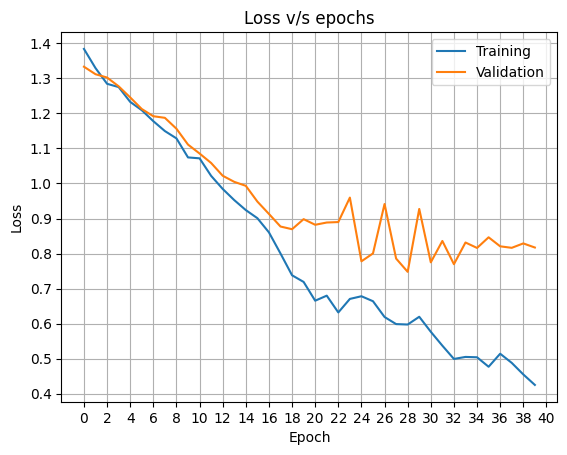

In [157]:
#LOSS V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 2., 0.1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss v/s epochs")
plt.savefig('Loss.png', bbox_inches='tight')
plt.show()

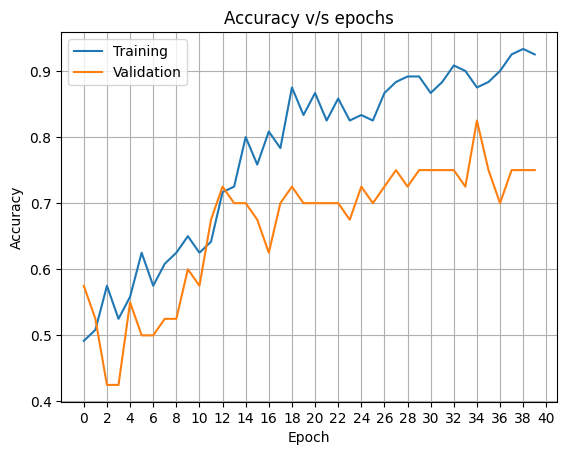

In [158]:
#ACCURACY V/S EPOCHS PLOT
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 2))
ax.set_yticks(np.arange(0, 1., 0.1))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title("Accuracy v/s epochs")
plt.savefig('Acc.png', bbox_inches='tight')
plt.show()

In [159]:
#EVALUATING ACCURACY AND LOSS ON TEST SET

score = model.evaluate(x_test,y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 18ms/step - loss: 0.9482 - accuracy: 0.7750 - auc_18: 0.7877
Test loss: 0.9482172131538391
Test accuracy: 0.7749999761581421


In [161]:
#SHOWING PREDICTIONS MADE BY THE MODEL ON TEST SET
y_pred = model.predict(x_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
print("Prediction by model: \n", y_pred.ravel())
print("True values of test set: \n", y_test)

2/2 [==============================] - 0s 13ms/step
Prediction by model: 
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 1.], dtype=float32)
True values of test set: 
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1])


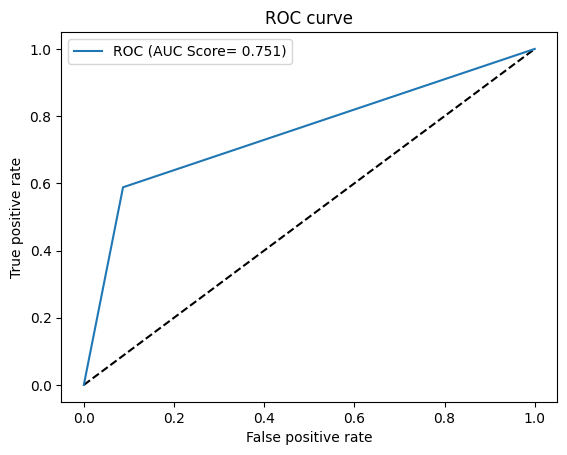

In [162]:
#PLOTTING ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (AUC Score= {:.3f})'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()